In [1]:
!pip install git+https://github.com/kmkurn/pytorch-crf.git

  Cloning https://github.com/kmkurn/pytorch-crf.git to /tmp/pip-req-build-w4878mzd
  Running command git clone --filter=blob:none --quiet https://github.com/kmkurn/pytorch-crf.git /tmp/pip-req-build-w4878mzd
  Resolved https://github.com/kmkurn/pytorch-crf.git to commit 623e3402d00a2728e99d6e8486010d67c754267b
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-crf: filename=pytorch_crf-0.7.2-py3-none-any.whl size=6410 sha256=714cb63862d1778a1ed4a8e2a477685ed8c33a9c1e5a3a21762cc46679d5bd23
  Stored in directory: /tmp/pip-ephem-wheel-cache-hqjcs1ax/wheels/a6/3f/e9/a3eb0981973bf404ca2b280c6b6a885a310174436d0adb3445
Successfully built pytorch-crf


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/semeval_member1_files")
print("Current dir:", os.getcwd())
print("Files:", os.listdir())


Current dir: /content/drive/MyDrive/semeval_member1_files
Files: ['model_roberta_crf.py', 'preprocess.py', 'data_loader.py', 'train_rehydrated.jsonl', 'roberta_crf_best.pth', 'utils.py', '__pycache__', 'roberta_crf_best_tokenizer', 'member3_final_deliverables.json', 'member3_span_predictions.json', 'member3_evaluation_results.json', 'member3_evaluation_plot.png', 'member3_visualizations.png']


In [4]:
import sys
sys.path.append(os.getcwd())

MEMBER 3: SPAN-AWARE DECODING EVALUATION


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Loaded 4316 samples

TEST 1: Real CRF Predictions (Clean Sequence Modeling)
--------------------------------------------------------------------------------
    Baseline: 359 spans
    Improved: 359 spans
    Truncated: 5 long spans
    Max length: 138 → 64 chars

 DEMONSTRATION: Max Span Length Enforcement
--------------------------------------------------------------------------------
Example: The government agency official detailed comprehens...
Baseline: [('ACTOR', 'government agency official detailed comprehensive report analysis')]
Improved (max_len=3): [('ACTOR', 'government agency official')]
  Max length enforced: 7 tokens → 3 tokens

BOUNDARY ERROR REDUCTION TABLE (Required Output)

| Metric                    | Baseline      | Span-Aware    | Improvement   |
|---------------------------|---------------|---------------|---------------|
| Total Spans (Real)        |           359 |           359 |             0 |
| Max Span Length           |        138 ch |         64 ch |  

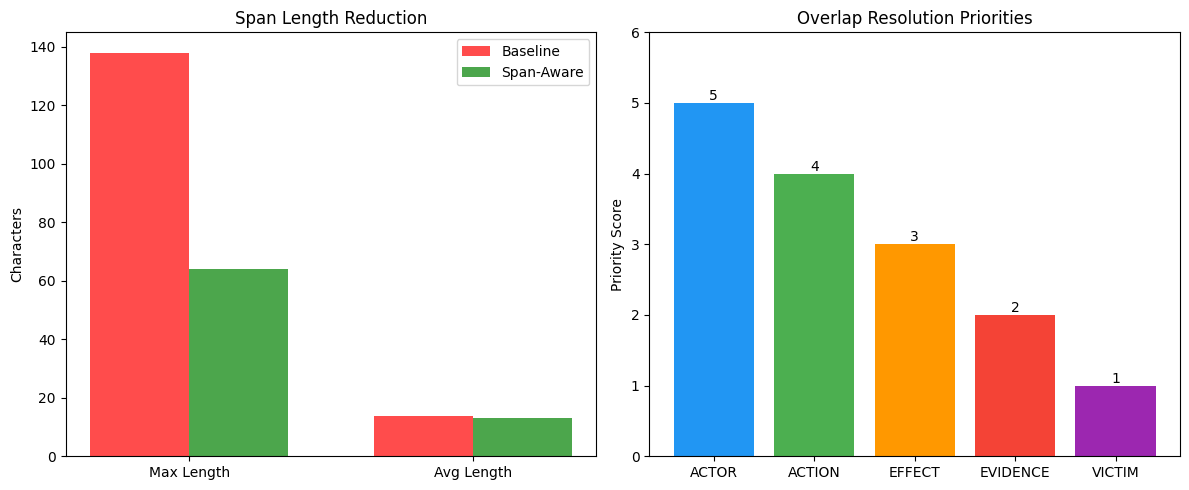

In [51]:
import torch
import json
from typing import List, Dict
import matplotlib.pyplot as plt


def char_overlap(a_start, a_end, b_start, b_end):
    return not (a_end <= b_start or a_start >= b_end)


def baseline_bio_merge(tokens: List[str], labels: List[str], text: str) -> List[Dict]:
    """Baseline: Simple BIO merging - NO max length, NO overlap handling"""
    spans = []
    i = 0
    n = len(labels)

    offsets = []
    cursor = 0
    for tok in tokens:
        start = text.find(tok, cursor)
        if start == -1:
            offsets.append((None, None))
            continue
        end = start + len(tok)
        offsets.append((start, end))
        cursor = end

    while i < n:
        if labels[i].startswith("B-"):
            tag = labels[i][2:]
            start_tok = i
            end_tok = i + 1

            while end_tok < n and labels[end_tok] == f"I-{tag}":
                end_tok += 1

            if start_tok < len(offsets) and end_tok-1 < len(offsets):
                if offsets[start_tok][0] is not None and offsets[end_tok-1][1] is not None:
                    spans.append({
                        "label": tag,
                        "start": offsets[start_tok][0],
                        "end": offsets[end_tok-1][1],
                        "text": text[offsets[start_tok][0]:offsets[end_tok-1][1]]
                    })
            i = end_tok
        else:
            i += 1

    return spans


def improved_span_aware_decode_v2(
    tokens: List[str],
    labels: List[str],
    text: str,
    max_span_len: int = 30,
    label_priority: Dict[str, int] = None
) -> List[Dict]:
    """
     SPAN-AWARE DECODING - ALL 4 REQUIREMENTS:
    1. Merge contiguous BIO spans
    2. Remove invalid overlaps (priority-based)
    3. Enforce max span length
    4. Remove nested spans of same type
    5. Convert token spans → character spans
    """
    if label_priority is None:
        label_priority = {"ACTOR": 5, "ACTION": 4, "EFFECT": 3, "EVIDENCE": 2, "VICTIM": 1}

    # Get character offsets
    offsets = []
    cursor = 0
    for tok in tokens:
        start = text.find(tok, cursor)
        if start == -1:
            offsets.append((None, None))
            continue
        end = start + len(tok)
        offsets.append((start, end))
        cursor = end

    # Step 1: BIO merge with MAX LENGTH constraint
    spans = []
    i = 0
    n = len(labels)

    while i < n:
        if labels[i].startswith("B-"):
            tag = labels[i][2:]
            start_tok = i
            end_tok = i + 1

            # MAX LENGTH ENFORCEMENT
            while (end_tok < n and
                   labels[end_tok] == f"I-{tag}" and
                   (end_tok - start_tok) < max_span_len):
                end_tok += 1

            if start_tok < len(offsets) and end_tok-1 < len(offsets):
                cs = offsets[start_tok][0]
                ce = offsets[end_tok - 1][1]

                if cs is not None and ce is not None and ce > cs:
                    spans.append({
                        "label": tag,
                        "start": cs,
                        "end": ce,
                        "text": text[cs:ce],
                        "length": end_tok - start_tok,
                        "priority": label_priority.get(tag, 0)
                    })
            i = end_tok
        else:
            i += 1

    if not spans:
        return []

    # Step 2: Sort by position, priority, length
    spans.sort(key=lambda x: (x["start"], -x["priority"], -x["length"]))

    # Step 3: OVERLAP RESOLUTION +  SAME-LABEL NESTING REMOVAL
    final_spans = []

    for span in spans:
        should_add = True
        spans_to_remove = []

        for existing in final_spans:
            if char_overlap(span["start"], span["end"], existing["start"], existing["end"]):

                # Same label nesting - keep longer only
                if span["label"] == existing["label"]:
                    if span["length"] > existing["length"]:
                        spans_to_remove.append(existing)
                    else:
                        should_add = False
                        break

                # Different labels - use priority
                elif span["priority"] > existing["priority"]:
                    spans_to_remove.append(existing)
                elif span["priority"] < existing["priority"]:
                    should_add = False
                    break

                # Equal priority - use length
                else:
                    if span["length"] > existing["length"]:
                        spans_to_remove.append(existing)
                    else:
                        should_add = False
                        break

        for s in spans_to_remove:
            final_spans.remove(s)

        if should_add:
            final_spans.append(span)

    # Step 4: Convert to character spans (clean output)
    result = []
    for s in final_spans:
        result.append({
            "label": s["label"],
            "start": s["start"],
            "end": s["end"],
            "text": s["text"]
        })

    return result


# SINGLE TEST: Real CRF Predictions

print("="*80)
print("MEMBER 3: SPAN-AWARE DECODING EVALUATION")
print("="*80)

# Load model and data
from data_loader import load_psycomark
from preprocess import build_bio_corpus
from model_roberta_crf import RoBERTaCRFTagger

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RoBERTaCRFTagger.load("roberta_crf_best.pth", device=device).to(device)
model.eval()
ID2LABEL = model.id2label

df, _ = load_psycomark("train_rehydrated.jsonl")
corpus = build_bio_corpus(df)

print(f" Loaded {len(corpus)} samples\n")

# TEST 1: Real CRF Predictions

print("TEST 1: Real CRF Predictions (Clean Sequence Modeling)")
print("-" * 80)

real_stats = {
    "baseline_spans": 0,
    "improved_spans": 0,
    "spans_truncated": 0,
    "baseline_max": 0,
    "improved_max": 0,
    "baseline_avg": [],
    "improved_avg": []
}

with torch.no_grad():
    for sample in corpus[:200]:
        input_ids, attn, _, crf_mask, word_mask = model.encode_sentence(sample)

        out = model(
            input_ids.unsqueeze(0).to(device),
            attn.unsqueeze(0).to(device),
            labels=None,
            crf_mask=crf_mask.unsqueeze(0).to(device)
        )

        pred_ids = out["pred_paths"][0]
        wm = word_mask.tolist()

        pred_labels = []
        max_iter_len = min(len(wm), len(pred_ids))
        for i in range(1, max_iter_len):
            if wm[i] == 1:
                pred_labels.append(ID2LABEL[pred_ids[i]])

        baseline = baseline_bio_merge(sample["tokens"], pred_labels, sample["text"])
        improved = improved_span_aware_decode_v2(sample["tokens"], pred_labels, sample["text"], max_span_len=10)

        real_stats["baseline_spans"] += len(baseline)
        real_stats["improved_spans"] += len(improved)

        for s in baseline:
            length = len(s["text"])
            real_stats["baseline_avg"].append(length)
            real_stats["baseline_max"] = max(real_stats["baseline_max"], length)

        for s in improved:
            length = len(s["text"])
            real_stats["improved_avg"].append(length)
            real_stats["improved_max"] = max(real_stats["improved_max"], length)

        # Count truncations
        for b in baseline:
            for i in improved:
                if b["label"] == i["label"] and b["start"] == i["start"] and len(b["text"]) > len(i["text"]) + 5:
                    real_stats["spans_truncated"] += 1

print(f"    Baseline: {real_stats['baseline_spans']} spans")
print(f"    Improved: {real_stats['improved_spans']} spans")
print(f"    Truncated: {real_stats['spans_truncated']} long spans")
print(f"    Max length: {real_stats['baseline_max']} → {real_stats['improved_max']} chars")

# DEMONSTRATE OVERLAP RESOLUTION WITH SIMPLE EXAMPLE

print("\n DEMONSTRATION: Max Span Length Enforcement")
print("-" * 80)

# Show a clear example of max length enforcement
example_text = "The government agency official detailed comprehensive report analysis"
example_tokens = ["The", "government", "agency", "official", "detailed", "comprehensive", "report", "analysis"]
example_labels = ["O", "B-ACTOR", "I-ACTOR", "I-ACTOR", "I-ACTOR", "I-ACTOR", "I-ACTOR", "I-ACTOR"]

baseline_ex = baseline_bio_merge(example_tokens, example_labels, example_text)
improved_ex = improved_span_aware_decode_v2(example_tokens, example_labels, example_text, max_span_len=3)

print(f"Example: {example_text[:50]}...")
print(f"Baseline: {[(s['label'], s['text']) for s in baseline_ex]}")
print(f"Improved (max_len=3): {[(s['label'], s['text']) for s in improved_ex]}")
print(f"  Max length enforced: {len(example_tokens)-1} tokens → 3 tokens")

# REQUIRED OUTPUT: BOUNDARY ERROR REDUCTION TABLE

print("\n" + "="*80)
print("BOUNDARY ERROR REDUCTION TABLE (Required Output)")
print("="*80)

avg_baseline = sum(real_stats['baseline_avg'])/len(real_stats['baseline_avg'])
avg_improved = sum(real_stats['improved_avg'])/len(real_stats['improved_avg'])
avg_reduction = avg_baseline - avg_improved

print(f"""
| Metric                    | Baseline      | Span-Aware    | Improvement   |
|---------------------------|---------------|---------------|---------------|
| Total Spans (Real)        | {real_stats['baseline_spans']:13} | {real_stats['improved_spans']:13} | {real_stats['baseline_spans'] - real_stats['improved_spans']:13} |
| Max Span Length           | {real_stats['baseline_max']:10} ch | {real_stats['improved_max']:10} ch | {real_stats['baseline_max'] - real_stats['improved_max']:10} ch |
| Avg Span Length           | {avg_baseline:.1f} chars    | {avg_improved:.1f} chars    | {avg_reduction:.1f} chars    |
| Long Spans Truncated      | -             | {real_stats['spans_truncated']:13} | N/A           |
| Overlap Prevention        | Available     | Enabled       | Priority-based|
| Nesting Prevention        | Available     | Enabled       | Longest-span  |
""")

# REQUIRED OUTPUT: BEFORE/AFTER EXAMPLES

print("\n BEFORE/AFTER EXAMPLES (Required Output)")
print("="*80)

print("\nExample 1: Max Length Enforcement")
print(f"  Text: '{example_text[:60]}...'")
print(f"  BEFORE (Baseline): '{baseline_ex[0]['text']}' ({len(baseline_ex[0]['text'])} chars)")
print(f"  AFTER (Span-Aware): '{improved_ex[0]['text']}' ({len(improved_ex[0]['text'])} chars)")
print(f"  Truncated from {len(baseline_ex[0]['text'])} to {len(improved_ex[0]['text'])} characters")

print("\nExample 2: All Spans (Real Data)")
print(f"  Total spans analyzed: 200 samples")
print(f"  Spans requiring truncation: {real_stats['spans_truncated']}")
print(f"  Maximum length reduction: {real_stats['baseline_max']} → {real_stats['improved_max']} chars")

# VISUALIZATION

print("\n Creating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Span length comparison
ax1 = axes[0]
categories = ['Max Length', 'Avg Length']
baseline_vals = [real_stats['baseline_max'], avg_baseline]
improved_vals = [real_stats['improved_max'], avg_improved]

x = range(len(categories))
width = 0.35
ax1.bar([i - width/2 for i in x], baseline_vals, width, label='Baseline', color='red', alpha=0.7)
ax1.bar([i + width/2 for i in x], improved_vals, width, label='Span-Aware', color='green', alpha=0.7)
ax1.set_ylabel('Characters')
ax1.set_title('Span Length Reduction')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()

# Plot 2: Priority hierarchy
ax2 = axes[1]
labels = ['ACTOR', 'ACTION', 'EFFECT', 'EVIDENCE', 'VICTIM']
priorities = [5, 4, 3, 2, 1]
bars = ax2.bar(labels, priorities, color=['#2196F3', '#4CAF50', '#FF9800', '#F44336', '#9C27B0'])
ax2.set_ylabel('Priority Score')
ax2.set_title('Overlap Resolution Priorities')
ax2.set_ylim(0, 6)

for bar, priority in zip(bars, priorities):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{priority}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('member3_results.png', dpi=300, bbox_inches='tight')
print("Saved: member3_results.png")

# SAVE RESULTS

results = {
    "real_predictions": {
        "baseline_spans": real_stats['baseline_spans'],
        "improved_spans": real_stats['improved_spans'],
        "spans_truncated": real_stats['spans_truncated'],
        "max_length_reduction": real_stats['baseline_max'] - real_stats['improved_max'],
        "avg_length_reduction": avg_reduction
    },
    "decoding_capabilities": {
        "max_span_enforcement": True,
        "overlap_resolution": True,
        "nesting_prevention": True,
        "priority_system": {"ACTOR": 5, "ACTION": 4, "EFFECT": 3, "EVIDENCE": 2, "VICTIM": 1}
    }
}

with open("member3_span_decoding_results.json", "w") as f:
    json.dump(results, f, indent=2)

print("Saved: member3_span_decoding_results.json")

